In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import random
import string
import numpy as np
import sys, os
import torch.utils.data as data

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [3]:
all_characters = string.printable
number_of_characters = len(all_characters)

In [4]:
def character_to_label(character):
    """Returns a one-hot-encoded tensor given a character.
    
    Uses string.printable as a dictionary.
        
    Parameters
    ----------
    character : str
        A character
        
    Returns
    -------
    one_hot_tensor : Tensor of shape (1, number_of_characters)
        One-hot-encoded tensor
    """
    
    character_label = all_characters.find(character)
        
    return character_label


In [5]:
def string_to_labels(character_string):
    
    return map(lambda character: character_to_label(character), character_string)


In [6]:
def pad_sequence(seq, max_length, pad_label=100):
    
    seq += [pad_label for i in range(max_length - len(seq))]
    
    return seq


In [7]:
class LyricsGenerationDataset(data.Dataset):
    
    def __init__(self, csv_file_path, minimum_song_count=None, artists=None):
        
        
        self.lyrics_dataframe = pd.read_csv(csv_file_path)
        
        if artists:
            
            self.lyrics_dataframe = self.lyrics_dataframe[self.lyrics_dataframe.artist.isin(artists)]
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        if minimum_song_count:
        
            # Getting artists that have 70+ songs
            self.lyrics_dataframe = self.lyrics_dataframe.groupby('artist').filter(lambda x: len(x) > minimum_song_count)
            # Reindex .loc after we fetched random songs
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        # Get the length of the biggest lyric text
        # We will need that for padding
        self.max_text_len = self.lyrics_dataframe.text.str.len().max()
        
        whole_dataset_len = len(self.lyrics_dataframe)
        
        self.indexes = range(whole_dataset_len)
        
        self.artists_list = list(self.lyrics_dataframe.artist.unique())
        
        self.number_of_artists = len(self.artists_list)
    
    
    def __len__(self):
        
        return len(self.indexes)
    
    
    def __getitem__(self, index):
        
        index = self.indexes[index]
        
        sequence_raw_string = self.lyrics_dataframe.loc[index].text
        
        sequence_string_labels = string_to_labels(sequence_raw_string)
        
        sequence_length = len(sequence_string_labels) - 1
        
        # Shifted by one char
        input_string_labels = sequence_string_labels[:-1]
        output_string_labels = sequence_string_labels[1:]
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_string_labels_padded = pad_sequence(input_string_labels, max_length=self.max_text_len)
        
        output_string_labels_padded = pad_sequence(output_string_labels, max_length=self.max_text_len, pad_label=-100)
        
        return (torch.LongTensor(input_string_labels_padded),
                torch.LongTensor(output_string_labels_padded),
                torch.LongTensor([sequence_length]) )



In [8]:
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)

    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]

    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, lengths_batch_sorted_list


class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        # Converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements
        
        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        embedded = self.encoder(input_sequences)

        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_sequences_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        
        logits = logits.transpose(0, 1).contiguous()
        
        logits_flatten = logits.view(-1, self.num_classes)
        
        return logits_flatten, hidden

    
trainset = LyricsGenerationDataset(csv_file_path='songdata.csv')

trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                              shuffle=True, num_workers=4, drop_last=True)


In [9]:
rnn = RNN(input_size=len(all_characters) + 1, hidden_size=512, num_classes=len(all_characters))
rnn.cuda()


RNN(
  (encoder): Embedding(101, 512)
  (gru): LSTM(512, 512, num_layers=2)
  (logits_fc): Linear(in_features=512, out_features=100)
)

In [10]:
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()


In [11]:
def sample_from_rnn(starting_sting="Why", sample_length=300, temperature=1):

    sampled_string = starting_sting
    hidden = None

    first_input = torch.LongTensor( string_to_labels(starting_sting) ).cuda()
    first_input = first_input.unsqueeze(1)
    current_input = Variable(first_input)

    output, hidden = rnn(current_input, [len(sampled_string)], hidden=hidden)

    output = output[-1, :].unsqueeze(0)

    for i in xrange(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature) ).data

        predicted_label = torch.multinomial(output_dist, 1)

        sampled_string += all_characters[int(predicted_label[0])]

        current_input = Variable(predicted_label.unsqueeze(1))

        output, hidden = rnn(current_input, [1], hidden=hidden)
    
    return sampled_string

<IPython.core.display.Javascript object>


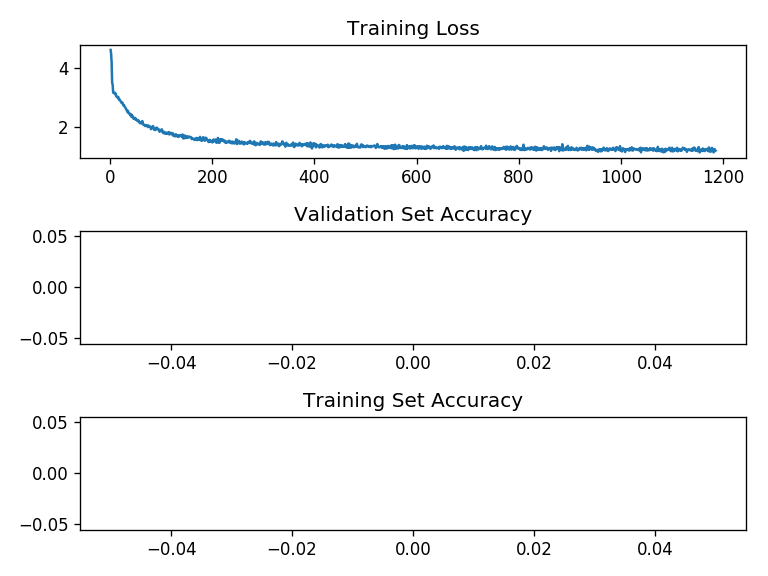

In [12]:
%matplotlib notebook

from matplotlib import pyplot as plt

# importing a list that can be binded with a figure and update
# the figure when being appended
from visualization import VizList

# Creating figure, axes and binding to lists 
f, (loss_axis, validation_axis, train_axis) = plt.subplots(3, 1)

loss_axis.plot([], [])
validation_axis.plot([], [])
train_axis.plot([], [])


loss_list = VizList()
validation_list = VizList()
train_list = VizList()

loss_list.bind_to_axis(loss_axis)
validation_list.bind_to_axis(validation_axis)
train_list.bind_to_axis(train_axis)

loss_axis.set_title('Training Loss')
validation_axis.set_title('Validation Set Accuracy')
train_axis.set_title('Training Set Accuracy')


plt.tight_layout()

In [ ]:
clip = 1.0
epochs_number = 1000

for epoch_number in xrange(epochs_number):

    for batch in trainset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
        
        optimizer.zero_grad()

        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)
        
        loss = criterion(logits, output_sequences_batch_var)
        loss_list.append( loss.data[0] )
        loss.backward()

        #torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

        optimizer.step()
        
    print(sample_from_rnn())
    torch.save(rnn.state_dict(), 'results/unconditional_rnn.pth')
    
    

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Why I didn't know why  
I found myself, I love you and it never knows of that rids  
I wanna see a thing I knew that You do.  
Oooh, ay, but any tonight  
I howned it and were eyes.  
Who wouldn't hide, just omans 'bout it up, gone.  
I don't know how arous, beach those gimme for you.  
Go look at her.


Ideally run at least for 50000 iterations...